#### 패키지 import

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#### 데이터 불러오기

In [3]:
d = pd.read_parquet('005930.parquet')

#### 데이터 준비

In [4]:
d['5d_max'] = d.rolling(5)['close'].max() # 오늘 포함 과거 5일 종가 중 최고값
d['5d_min'] = d.rolling(5)['close'].min() # 오늘 포함 과거 5일 종가 중 최저값
d['last_1d_close'] = d['close'].shift(1) # 전일 종가
d['20d_mean'] = d.rolling(20)['close'].mean() # 20일 이동평균

#### 전략 백테스팅

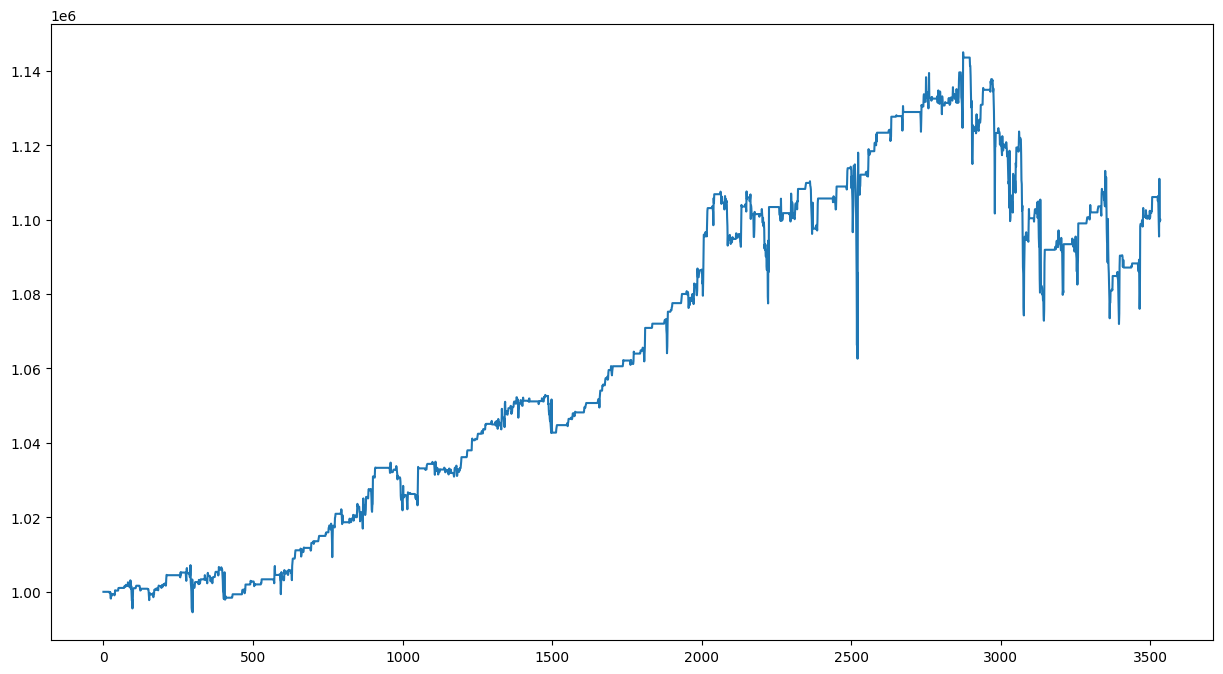

In [5]:
################ 백테스팅 파라미터 ################
holding_cash = 1_000_000 # 보유 현금
position = 0 # 현재 보유 포지션
avg_price = 0 # 평단가
slippage = 0.004 # 슬리피지
daily_total_value = [] # 일별 총 포트폴리오 가치
################ 백테스팅 파라미터 ################

################ 전략 파라미터 ################
holding_time_passed = 0 # 마지막 매수 후 경과 일수
################ 전략 파라미터 ################

# for 문으로 하루씩 백테스팅 진행
for idx,data in d.iterrows():
    daily_total_value.append(0)

    if (data['close'] < data['20d_mean']) and (data['close'] == data['5d_min']):
        if holding_cash > 1*data['close']:
            position += 1
            holding_cash -= 1 * data['close']
            avg_price = data['close']
            holding_time_passed = 0

    # 마지막 매수 3일 후 매도
    if position > 0 and holding_time_passed == 3:
        holding_cash += position * data['close'] * (1-slippage)
        position = 0
        avg_price = 0

    # 오늘의 마무리
    if position > 0:
        holding_time_passed += 1
    
    daily_total_value[-1] = holding_cash + position * data['close']

plt.figure(figsize=(15,8))
plt.plot(daily_total_value)

#### 전략 성과 측정

총 수익률: 9.99%
------------------------------------------------
총 백테스팅 기간: 14.14년
연 수익률: 0.68%
------------------------------------------------
일 수익률: 0.00%, 일 변동성: 0.00%
Sharpe ratio: 0.23
------------------------------------------------
MDD: -6.38%


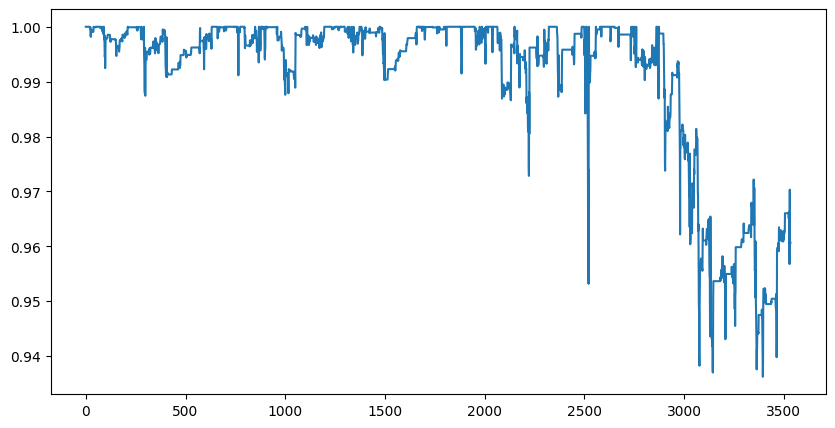

------------------------------------------------


In [6]:
# 전략 총 수익률 계산
total_return_pct = daily_total_value[-1]/daily_total_value[0]
print('총 수익률: {:.2f}%'.format((total_return_pct-1)*100))

print('------------------------------------------------')

# 1년을 250일로 가정, 연 복리 수익률 계산
total_years = len(daily_total_value)/250
print('총 백테스팅 기간: {:.2f}년'.format(total_years))

import math
annaul_return = math.pow(total_return_pct,1/total_years)

print('연 수익률: {:.2f}%'.format((annaul_return-1)*100))

print('------------------------------------------------')

# Sharpe Ratio
daily_return = math.pow(total_return_pct,1/len(daily_total_value))
daily_std = pd.DataFrame(daily_total_value).pct_change().std()[0]

print('일 수익률: {:.2f}%, 일 변동성: {:.2f}%'.format((daily_return-1)*100,daily_std))
print('Sharpe ratio: {:.2f}'.format(((daily_return-1)/daily_std)*np.sqrt(250)))

print('------------------------------------------------')

# MDD 계산
tv = pd.DataFrame(daily_total_value)
dd = tv/tv.cummax()
print('MDD: {:.2f}%'.format((dd.min()-1)[0]*100))


plt.figure(figsize=(10,5))
plt.plot(dd)
plt.show()

print('------------------------------------------------')


#### 벤치마크 적용

총 수익률: 374.04%
------------------------------------------------
총 백테스팅 기간: 14.14년
연 수익률: 11.64%
------------------------------------------------
일 수익률: 0.04%, 일 변동성: 0.02%
Sharpe ratio: 0.42
------------------------------------------------
MDD: -42.20%


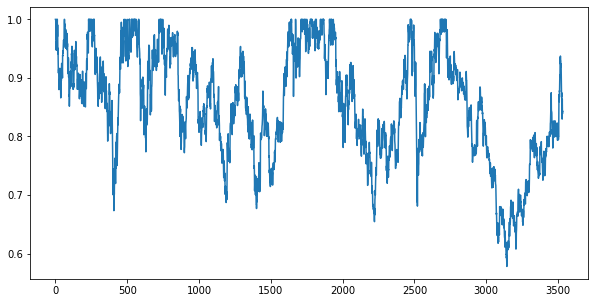

------------------------------------------------


In [14]:
# 삼성전자 Buy & Hold의 수익률 계산

bm_daily_total_value = d['close'].values/d['close'].values[0]

# 전략 총 수익률 계산
total_return_pct = bm_daily_total_value[-1]/bm_daily_total_value[0]
print('총 수익률: {:.2f}%'.format((total_return_pct-1)*100))

print('------------------------------------------------')

# 1년을 250일로 가정, 연 복리 수익률 계산
total_years = len(bm_daily_total_value)/250
print('총 백테스팅 기간: {:.2f}년'.format(total_years))

import math
annaul_return = math.pow(total_return_pct,1/total_years)

print('연 수익률: {:.2f}%'.format((annaul_return-1)*100))

print('------------------------------------------------')

# Sharpe Ratio
daily_return = math.pow(total_return_pct,1/len(bm_daily_total_value))
daily_std = pd.DataFrame(bm_daily_total_value).pct_change().std()[0]

print('일 수익률: {:.2f}%, 일 변동성: {:.2f}%'.format((daily_return-1)*100,daily_std))
print('Sharpe ratio: {:.2f}'.format(((daily_return-1)/daily_std)*np.sqrt(250)))

print('------------------------------------------------')

# MDD 계산
tv = pd.DataFrame(bm_daily_total_value)
dd = tv/tv.cummax()
print('MDD: {:.2f}%'.format((dd.min()-1)[0]*100))


plt.figure(figsize=(10,5))
plt.plot(dd)
plt.show()

print('------------------------------------------------')


#### 전략과 벤치마크 수익률 비교

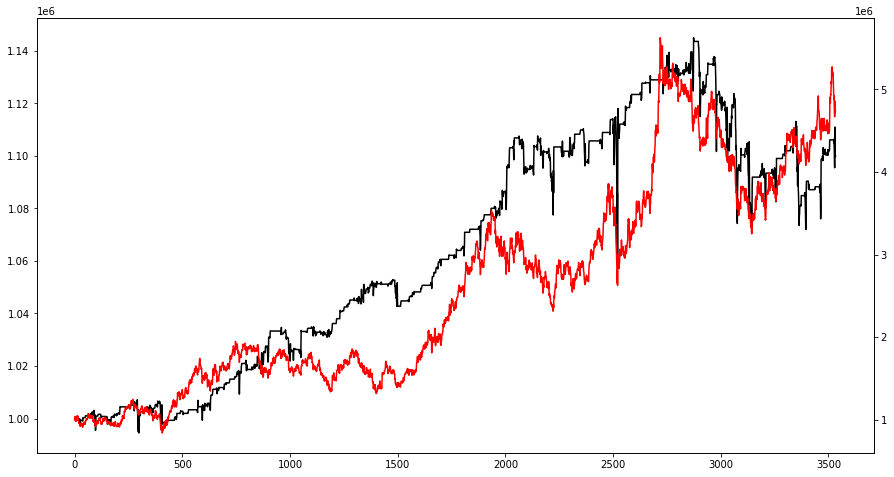

In [15]:
plt.figure(figsize=(15,8))
plt.plot(daily_total_value,c='k')
plt.twinx().plot(bm_daily_total_value*daily_total_value[0],c='r')